In [1]:
import os
import sys
parent = os.path.realpath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(parent)

import numpy as np
from databases.sql_connect import create_connection
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

import matplotlib

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

conn = None
sns.set_theme()
sns.set(context="paper", style="darkgrid", font="Times New Roman")
cm = 1/2.54
DB_CORR = os.path.join(parent,"databases", "TEMPRO_DB230416_Corr.db")
assert(os.path.exists(DB_CORR))
FONTSIZE = 8

# Calculate the equivalent, pondered LCA Impacts of several precious metals
EUR = 1.09

prices = {"Al": 2.86,  # https://markets.businessinsider.com/commodities/aluminum-price
          "Dy": 380/EUR,
          "Fe": 0.1319/EUR,  # https://www.dailymetalprice.com/metalprices.php?c=fe&u=kg&d=1
          "Nd": 173.30/EUR,
          # https://www.statista.com/statistics/1009173/tantalum-price/#:~:text=In%202021%2C%20the%20price%20of,per%20kilogram%20of%20Ta2O5%20content.
          "Ta":  158/EUR,
          "Y": 32.0/EUR,
          "Au": 59214.60/EUR,
          "Ag": 705.90/EUR,
          "Pd": 64919.14/EUR,
          "Cu": 9.4567/EUR, }

# "Al": 1.44 Ecovinvent
symbols = {"output aluminium scrap, post-consumer, prepared for melting": "Al",
           "Dysprosium": "Dy",
           "output iron scrap, sorted, pressed": "Fe",
           "Neodymium": "Nd",
           "Tantalum": "Ta",
           "Yttrium": "Y",
           "Gold": "Au",
           "Silver": "Ag",
           "Palladium": "Pd",
           "output copper scrap, sorted, pressed": "Cu",
           "PCB Pyrolysis": "Recyc.",
           "PCB HM": "Recyc.",
           "PCB ER": "Recyc.",
           "PCB Bioleech": "Recyc.",
           "Tantal Recycling": "Recyc. Ta"}

C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_21032\4141812839.py:18: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [2]:
def get_recovery_impacts(ps_id,method,cmap,impact="CED - total"):

    ps_id=str(ps_id)

    conn = create_connection(DB_CORR)

    queryLCA_1000 = f'SELECT * FROM [1000LCAResults]'
    lca = pd.read_sql_query(queryLCA_1000, conn)
    lca_ced1 = lca[lca["Category"]==impact]
    lca_ced1.set_index("ProductSystemID", inplace=True)


    # query for scraps
    queryLCA_2000 = f'SELECT * FROM [2000LCAResults]'
    lca2 = pd.read_sql_query(queryLCA_2000, conn)
    lca_ced2 = lca2[lca2["Category"]==impact]
    lca_ced2 = lca_ced2[lca_ced2["ProductSystemID"]>2900]
    lca_ced2.set_index("ProductSystemID", inplace=True)
    

    #get ced data for the recycling process
    queryLCA_8000 = f'SELECT * FROM [8000LCAResults]'
    lca8 = pd.read_sql_query(queryLCA_8000, conn)
    lca_ced8 = lca8[lca8["Category"]==impact]
    lca_ced8.set_index("ProductSystemID", inplace=True)


    # get inventories for the part ID = 3208 and for the method
    query_recy=f'SELECT * FROM [9000Exchanges]' 
    exc9= pd.read_sql_query(query_recy, conn)

    exc9= exc9[exc9["9000Name"].str.contains(ps_id)==True] 
    exc9= exc9[exc9["9000Name"].str.contains(method)==True]
    exc9= exc9[['9000ID', '9000Name', '1000Materials', '2000Parts',
        '8000Recycling', 'ExchangeName','Amount']]
    exc9["CED_PS"]=np.nan
    exc9["Symbol"]=np.nan
    for idx in exc9.index:
        if exc9.at[idx, "1000Materials"]>1000:
            mat= exc9.at[idx, "1000Materials"]
            exc9.at[idx, "CED_PS"]=lca_ced1.at[mat,"Result"]

        if exc9.at[idx, "2000Parts"]>2000:
            mat= exc9.at[idx, "2000Parts"]
            exc9.at[idx, "CED_PS"]=lca_ced2.at[mat,"Result"]

        if exc9.at[idx, "8000Recycling"]>8000:
            mat= exc9.at[idx, "8000Recycling"]
            exc9.at[idx, "CED_PS"]=lca_ced8.at[mat,"Result"]
        
        exc9.at[idx, "Symbol"]=symbols[exc9.at[idx,"ExchangeName"]]

    exc9["Contrib"]=exc9["Amount"]*exc9["CED_PS"]
    exc9_res = exc9[["Symbol","Amount","Contrib"]]      
    exc9_res=exc9_res.groupby("Symbol").sum()
    exc9_res=exc9_res.sort_values("Contrib", ascending=False)
    base =[0]
    for x in exc9_res["Contrib"][0:-1]:
        b = x+base[-1]
        base.append(b)
    exc9_res["Base"]=base


    cmap = matplotlib.cm.get_cmap(cmap)
    max_recovery = min([x for x in exc9_res["Contrib"] if x<0])
    exc9_res["Color"] = "blue"
    for idx in exc9_res.index:
        if exc9_res.at[idx,"Contrib"]<0:
            proportion = exc9_res.at[idx,"Contrib"]/max_recovery
            proportion = 0.5+0.5*proportion
            color = cmap(proportion)
            exc9_res.at[idx,"Color"]=matplotlib.colors.to_hex(color, keep_alpha=True)

    return exc9_res

In [3]:
def get_impacts_recovery(ps_id=3208, impact = "CED - Total"):
    colormaps= ["Reds", "Purples", "Oranges","Greens"]
    methods= ["pyrolysis", "HM", "ER", "bioleeching"]
    series={}
    for method in methods:
        exc9_res=  get_recovery_impacts(ps_id,method,colormaps[0], impact=impact)
        exc9_res["UnitPrice"]=np.nan
        exc9_res["TotalValue"]=np.nan
        exc9_res["TotalValue-perc"]=np.nan
        exc9_res["ContribEconAloc"]=np.nan
        exc9_res["ContribPhysical"]=np.nan

        for idx in exc9_res.index:
            if idx!="Ta" and idx in prices.keys():
                exc9_res.at[idx,"UnitPrice"]=prices[idx]
                exc9_res.at[idx,"TotalValue"]=-exc9_res.at[idx,"Amount"]*prices[idx]
        total_value = exc9_res["TotalValue"].sum()
        for idx in exc9_res.index:
            if idx!="Ta" and idx in prices.keys():
                exc9_res.at[idx,"TotalValue-perc"]=exc9_res.at[idx,"TotalValue"]/total_value
                exc9_res.at[idx,"ContribEconAloc"]=exc9_res.at[idx,"TotalValue-perc"]*exc9_res.at["Recyc.", "Contrib"]
                exc9_res.at[idx,"ContribPhysical"]=-exc9_res.at[idx,"ContribEconAloc"]/exc9_res.at[idx, "Amount"]

        exc9_res
        idx= "Ta"
        exc9_res.at[idx,"UnitPrice"]=prices[idx]
        exc9_res.at[idx,"TotalValue"]=-exc9_res.at[idx,"Amount"]*prices[idx]
        total_value_Ta = exc9_res.at[idx,"TotalValue"]
        exc9_res.at[idx,"TotalValue-perc"]=exc9_res.at[idx,"TotalValue"]/total_value_Ta
        exc9_res.at[idx,"ContribEconAloc"]=exc9_res.at[idx,"TotalValue-perc"]*exc9_res.at["Recyc. Ta", "Contrib"]
        exc9_res.at[idx,"ContribPhysical"]=-exc9_res.at[idx,"ContribEconAloc"]/exc9_res.at[idx, "Amount"]

        exc9_res=exc9_res[exc9_res["UnitPrice"]>0]
        exc9_res_c = exc9_res["ContribPhysical"]
        exc9_res_c=exc9_res_c.rename("method")
        series[method]=exc9_res_c
    # For Tantal it is separated because the process is separated....

    result = pd.DataFrame(series)
      
    conn = create_connection(DB_CORR)

    # put the 1000LCA Results
    queryLCA_1000 = 'SELECT * FROM [1000LCAResults]'
    lca1 = pd.read_sql_query(queryLCA_1000, conn)
    lca_ced1 = lca1[lca1["Category"]=="CED - total"]
    lca_ced1.set_index("ProductSystemID", inplace=True)
    lca_ced1

    # I have to put symbols
    q1=  'SELECT * FROM [1000Materials]'
    list1 = pd.read_sql_query(q1, conn)
    list1.set_index("Symbol", inplace=True)
    list1["Impact"]=np.nan
    for idx in list1.index:
        id = list1.at[idx,"ID"]
        if id in lca_ced1.index:
            list1.at[idx,"Impact"] = lca_ced1.at[id, "Result"]


    result["RawMat"]=np.nan
    for idx in result.index:
        result.at[idx,"RawMat"]=list1.at[idx,"Impact"]
    cols = result.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    result_p=result[cols]
    new_cols ={"pyrolysis":"Pyrolysis", "HM":"Hydrometallurgical" , "ER": "Electrochemical" , "bioleeching":"Bioleeching",
     "RawMat": "Raw Material"}
    result_p.rename(columns=new_cols, inplace=True)

    return result_p


In [4]:
q3=  'SELECT * FROM [3000Pieces]'
conn = create_connection(DB_CORR)
list3 = pd.read_sql_query(q3, conn)
list3.set_index("ID", inplace=True)


min() arg is an empty sequence
3200
'Recyc.'
3201
"['Pd'] not found in axis"
3220
"['Pd'] not found in axis"
3221
min() arg is an empty sequence
3223
"['Pd'] not found in axis"
3228


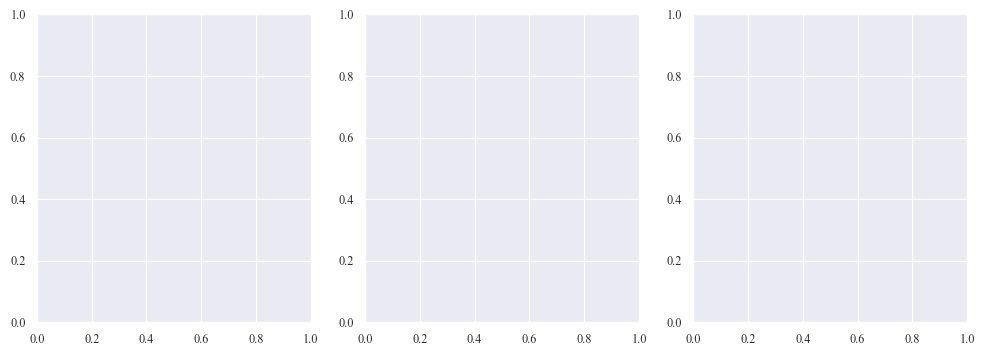

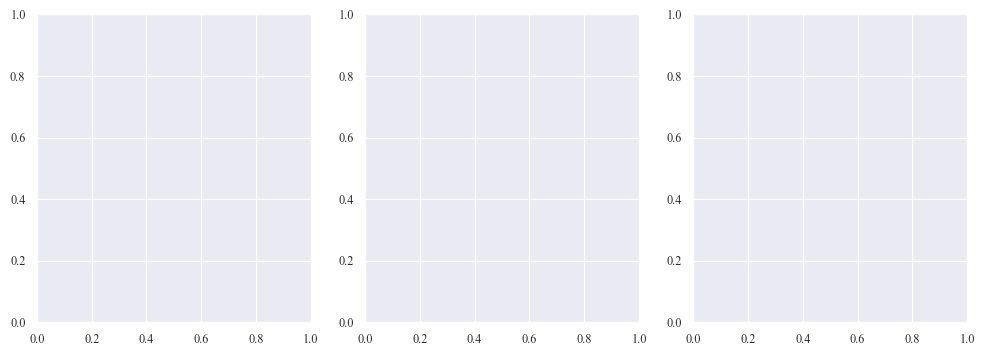

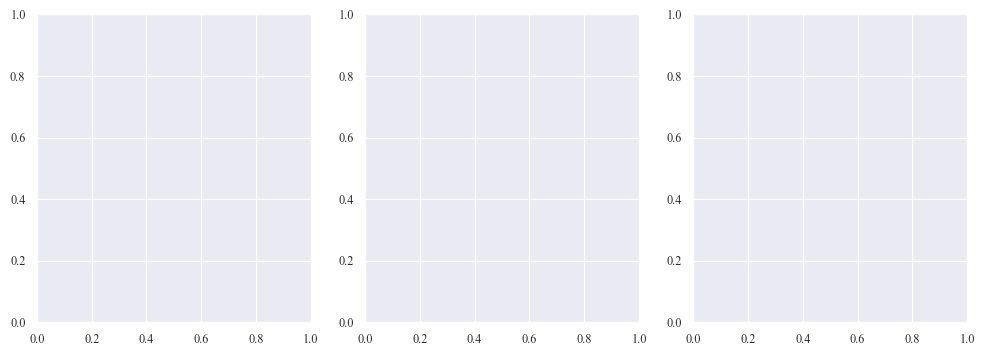

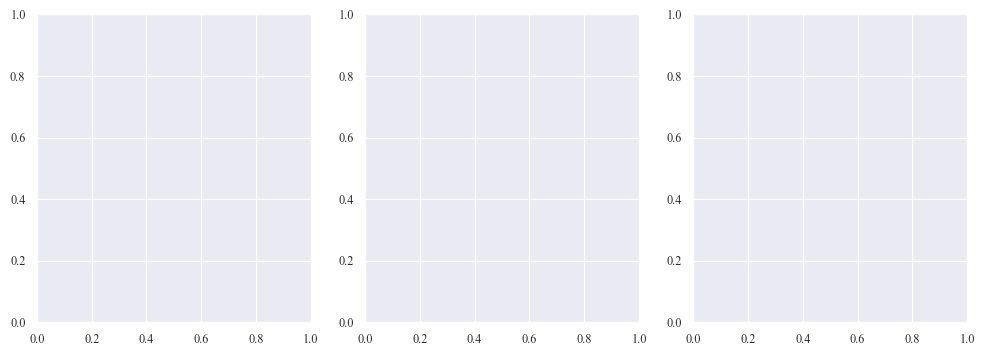

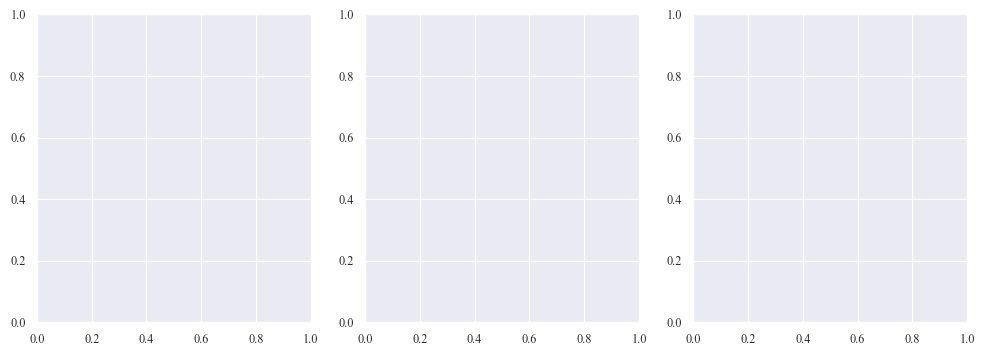

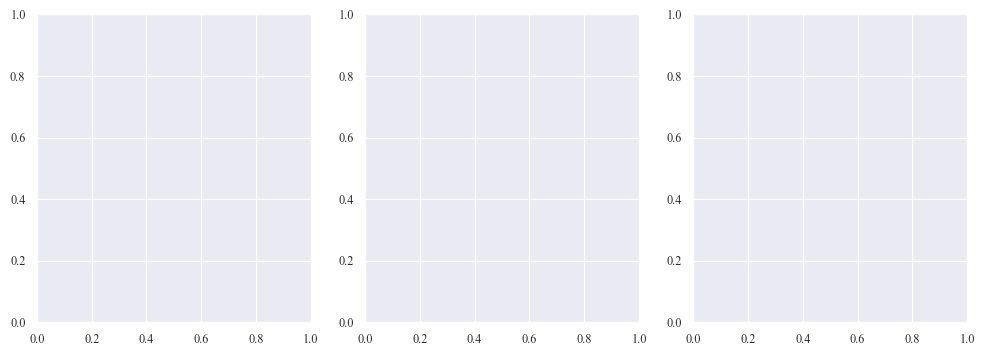

In [5]:

cats = {"CED - total": "CED",
        "CExD - metals": "CExD",
        "ADP": "ADP",
        "EI-Minerals- Total": "ADP\nEI",
        "GPR-Minerals- Total": "GPSR",
        "CML-climate change (GWP 100a)": "GWP",
        "ReCiPe Midpoint (E) - metal depletion (MDP)": "MDP",
        "ReCiPe Endpoint (E - A) - total (total)": "Total",
        }

full_label = {
    'CED': 'Primary Energy Demand [MJ-eq]',
    'CExD': 'Primary Exergy Demand [MJ-eq]',
    'ADP': 'Abiotic Depletion Potential [kg Sb-eq]',
    'ADP\nEI': 'ADP - Economic Importance [kg Sb-eq]',
    'GPSR': 'Geo-Political Suppy Risk [1]',
    'GWP': 'Greenhouse Emissions [kg CO2-eq]',
    'MDP': 'Metal Depletion Potential [kg Fe-eq]',
    'Total': 'ReCiPe-Total Impacts',
}

impacts = ["CED - total",
 "CExD - metals",
 "ReCiPe Endpoint (E - A) - total (total)"
 ]
for ps_id in range(3200,3230):#, 3208,3218]:#, 3208,3219]:
    try:#if True:
        fig,axs=plt.subplots(1,3, figsize=(12,4))
        for i in range(3):
            impact= impacts[i]
            result_p=get_impacts_recovery(ps_id,impact)#"ADP-Minerals- Total") # "CED - total")
            max = result_p["Raw Material"]
            for c in list(result_p.columns):
                result_p[c]=result_p[c]/max
            result_p.drop("Pd", inplace=True)
            result_p.drop("Dy", inplace=True)
            result_p.drop("Al", inplace=True)

            result_p.plot(kind="bar", ax=axs[i], width=0.666)
            axs[i].set_yscale("log")
            axs[i].set_xlabel("")
            label = full_label[cats[impact]]
            axs[i].set_ylabel(label, fontsize=FONTSIZE)
            if i !=2:
                axs[i].get_legend().remove()
            else:
                axs[i].legend(bbox_to_anchor=(-0.8, -0.2), loc="lower center", ncol=5)
            
            for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
                label.set_fontsize(FONTSIZE)
                label.set_x(0.03)

        ps_name= list3.at[ps_id,"Name"]
        #fig.suptitle(f"Material Gathering Impacts from Recycling from {ps_name}", fontweight="bold") 
        
        fig.savefig(f"RecoveryImpacts/ImpactCompar{ps_id}_{ps_name}].png",bbox_inches='tight', dpi=600)
        plt.close()
    except Exception as e:
        print(e)
        print(ps_id)